```markdown
Summary

This notebook is a test file in which you can have a clear understanding of some of the features of our pipeline, the information that we can extracted, and the visualization of our results: (Below are a summary list created by generated VScode Copilot)

1. **Environment Setup**:
    - Import necessary libraries such as `os`, `torch`, `cv2`, `numpy`, `supervision`, `random`, `matplotlib`, `pyefd`, and `mahotas`.
    - Define paths and load models for YOLO and SAM (Segment Anything Model).

2. **YOLO Prediction**:
    - Define a function to predict bounding boxes using the YOLO model.
    - Extract bounding boxes for a specific frame and z-height.

3. **Mask Prediction**:
    - Use the SAM model to predict masks for the detected bounding boxes.
    - Annotate and visualize the source and segmented images.

4. **Contour Extraction**:
    - Extract contours from the predicted masks.
    - Visualize the contours on the original image.

5. **Elliptic Fourier Descriptors (EFD)**:
    - Calculate and visualize the EFD for the extracted contours.
    - Reconstruct and visualize the contour using EFD.

6. **Shape Metrics Calculation**:
    - Calculate various shape metrics such as EFC ratio, solidity, and circularity for the contours.

7. **Haralick Features**:
    - Analyze and visualize Haralick texture features within the cell contours.

8. **Intensity Analysis**:
    - Calculate the average intensity of the masked regions.
    - Adjust the masks based on intensity thresholds and visualize the results.

This notebook provides a detailed workflow for image segmentation, contour extraction, shape analysis, texture analysis, and intensity analysis, making it a valuable resource for image processing tasks.
```

In [ ]:
!nvidia-smi

Tue Nov 12 15:55:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:01:00.0 Off |                  Off |
| 36%   31C    P8              17W / 450W |  16391MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## TEST CONTOUR & EFC ratio

In [30]:
import os

HOME = '/home/wl/4ipipeline/PIPLINE/pipeline'
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

/home/wl/4ipipeline/PIPLINE/pipeline/weights/sam_vit_h_4b8939.pth ; exist: True


In [31]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [32]:
import torch
import cv2
from ultralytics import YOLO

# Load the model

model = YOLO('/home/wl/4ipipeline/PIPLINE/MODEL_0402/runs/detect/train2/weights/best.pt')

In [33]:
def yolo_prediction(z_number, frame):
    # this functions choose pictures from all four rounds that share the same z-height
    # then predict the bounding boxes based on the first round using yolo model
    file_path = f'/home/wl/4ipipeline/PIPLINE/4I_Formal/WT_Stitched/frame_{frame}/'
    image = file_path + f'R1/{z_number}.png'
    predict = model.predict(image, conf = 0.5, iou = 0.3, imgsz = 640)
    boxes = predict[0].boxes
    return boxes

In [34]:
z_number = 3
frame = 2
boxes = yolo_prediction(z_number, frame)
bbox = []
for box in boxes:
    tensor_boxes = torch.tensor(box.xyxy)
    tensor_boxes_cpu = tensor_boxes.cpu()
    box1 = tensor_boxes_cpu.numpy()
    bbox.append(box1)
print(bbox)


image 1/1 /home/wl/4ipipeline/PIPLINE/4I_Formal/WT_Stitched/frame_2/R1/3.png: 640x640 55 cells, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[array([[     1589.5,      721.42,        1766,      895.45]], dtype=float32), array([[     925.95,      827.47,      1142.1,      1011.6]], dtype=float32), array([[     1505.9,      1167.7,      1686.1,      1378.7]], dtype=float32), array([[     1572.7,      942.31,        1743,      1132.2]], dtype=float32), array([[     1079.4,      242.33,      1306.1,      487.58]], dtype=float32), array([[     1241.2,      1345.5,      1435.4,        1563]], dtype=float32), array([[      974.6,      1053.1,      1183.1,      1249.1]], dtype=float32), array([[     1547.3,      1481.5,      1699.2,      1674.3]], dtype=float32), array([[     613.98,      539.71,      799.25,      733.36]], dtype=float32), array([[     1272.1,       180.9,        1462,      336.59]], dtype=float32), array([[     1289.3,      962.94,        1513,      1152.1]], dtype=float32), array([[     1206.4,      455.26,      1428.8,      649.76]], dtype=float32), array([[     1686.1,      1725.3,      1852.6,      1915.3]], d

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


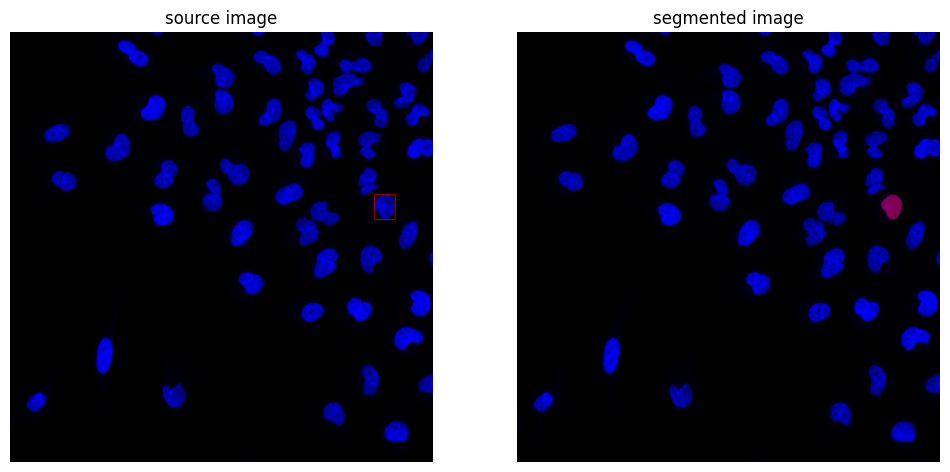

In [45]:
import cv2
import numpy as np
import supervision as sv
import random

IMAGE_PATH='/home/wl/4ipipeline/PIPLINE/4I_Formal/WT_Stitched/frame_2/channels/R3ch0.png'
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

rand_int = random.randint(0, 35)
box=bbox[rand_int]
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

<class 'numpy.ndarray'>
1
132


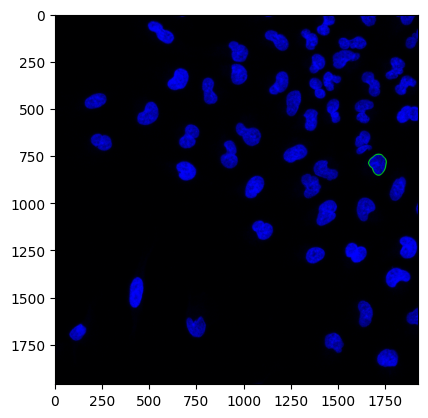

In [46]:
import matplotlib.pyplot as plt
# Assuming you're interested in the first mask
mask = masks[0]

# Convert the mask to a format that OpenCV can use
mask_opencv = np.uint8(mask * 255)

# Find the contours (boundaries) of the objects in the mask
contours, _ = cv2.findContours(mask_opencv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(type(contours[0]))
print(len(contours))
print(len(contours[0]))
# Now, contours[0] contains the boundary of the first object in the mask
# You can draw it on the image like this:
cv2.drawContours(image_rgb, contours, -1, (0,255,0), 3)
# Display the image with the drawn contours
plt.imshow(image_rgb)


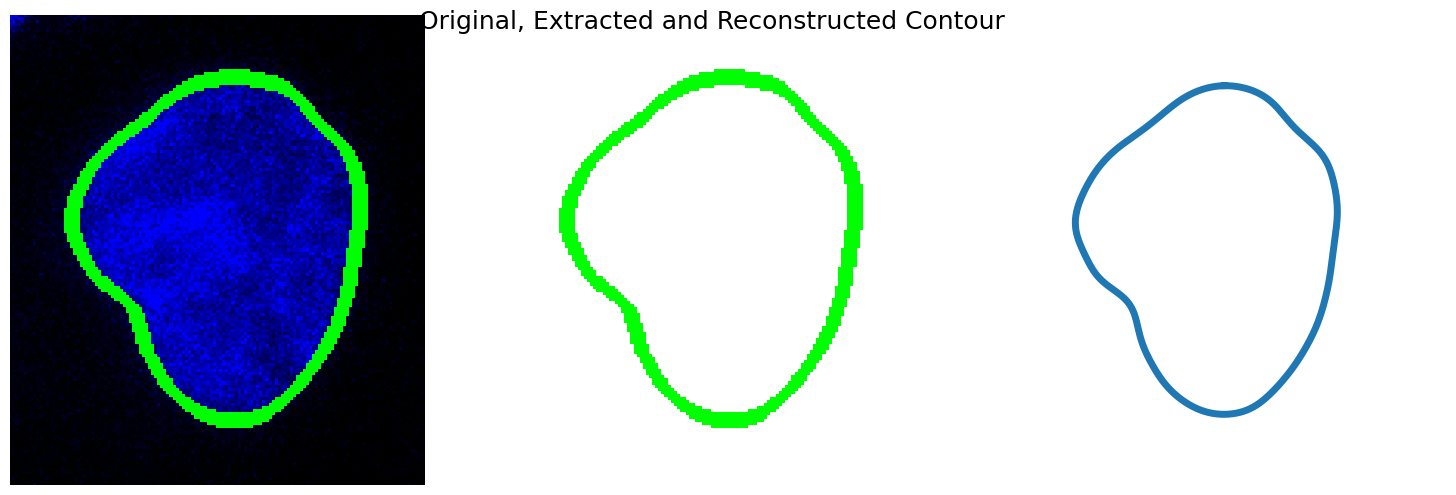

In [47]:
from pyefd import elliptic_fourier_descriptors, reconstruct_contour
x, y, w, h = cv2.boundingRect(contours[0])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cv2.drawContours(image_rgb, contours, -1, (0,255,0), 3)
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.xlim(x - 20, x + w + 20)  # Zoom out a little bit
plt.ylim(y + h + 20, y - 20)  # Zoom out a little bit

plt.subplot(1, 3, 2)
blank_image = np.ones_like(image_rgb) * 255
cv2.drawContours(blank_image, contours, -1, (0, 255, 0), 3)
plt.imshow(blank_image)
plt.axis('off')  # Hide the axis
plt.xlim(x - 20, x + w + 20)  # Zoom out a little bit
plt.ylim(y + h + 20, y - 20)  # Zoom out a little bit

plt.subplot(1, 3, 3)
contour = contours[0]
contour = contour.reshape(-1, 2)
coeffs = elliptic_fourier_descriptors(contour, order=15)
reconstructed_contour = reconstruct_contour(coeffs, num_points=1000)
rotation_matrix = np.array([[0, -1], [1, 0]])
rotated_contour = np.dot(reconstructed_contour, rotation_matrix)
mirror_matrix = np.array([[0, -1], [-1, 0]])
mirrored_contour = np.dot(rotated_contour, mirror_matrix)
plt.plot(mirrored_contour[:, 0], mirrored_contour[:, 1], linewidth = 5)
plt.axis('equal')
plt.axis('off')
x0, x1 = plt.xlim()
x_center = (x0 + x1) / 2
y0, y1 = plt.ylim()
y_center = (y0 + y1) / 2
plt.xlim(x_center - w/2 - 35, x_center + w/2 + 35)
plt.ylim(y_center - h/2 - 35, y_center + h/2 + 35)
plt.tight_layout()

plt.suptitle('Original, Extracted and Reconstructed Contour', fontsize=18)
plt.show()

### EFC ratio

In [48]:
from pyefd import elliptic_fourier_descriptors
from math import sqrt

contour = contours[0]
contour = contour.reshape(-1, 2)

def cal_EFC_ratio(contour):
    coeffs = elliptic_fourier_descriptors(contour, order=15)
    down = 0
    for key, value in enumerate(coeffs):
        if key == 0:
            up = sqrt(value[0]**2 + value[1]**2) + sqrt(value[2]**2 + value[3]**2)
        else:
            down += sqrt(value[0]**2 + value[1]**2) + sqrt(value[2]**2 + value[3]**2)
    return up/down

print(cal_EFC_ratio(contour))

5.589357195575892


### Solidity
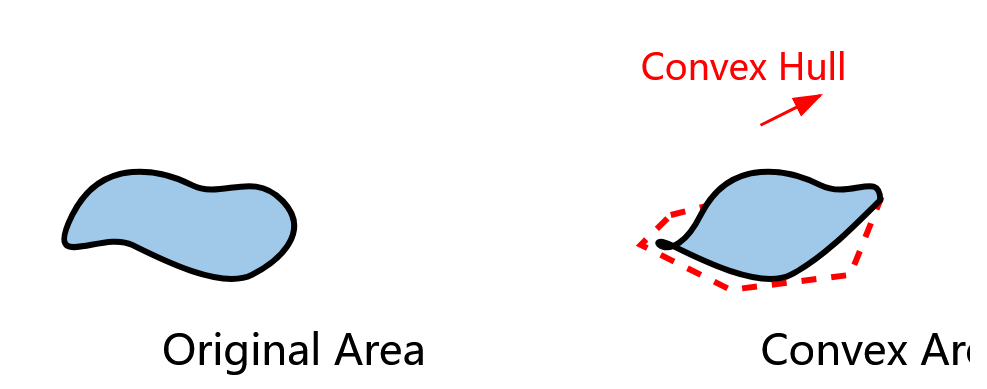

In [49]:
def calculate_solidity_from_contour(contour):
    """
    Calculate solidity for a single contour.
    
    Args:
        contour: OpenCV contour array
    Returns:
        float: solidity value
        float: adjusted solidity value (1-solidity)*100
    """
    # Calculate the area of the contour
    area = cv2.contourArea(contour)
    
    # Calculate the convex hull
    hull = cv2.convexHull(contour)
    
    # Calculate the area of the convex hull
    hull_area = cv2.contourArea(hull)
    
    # Calculate solidity
    solidity = float(area) / hull_area if hull_area > 0 else 0
    
    # Calculate adjusted solidity according to your formula
    adjusted_solidity = (1 - solidity) * 100
    
    return solidity, adjusted_solidity

print(calculate_solidity_from_contour(contours[0]))

(0.9799785723851614, 2.0021427614838605)


### Circularity

In [50]:
def calculate_shape_metrics(contour):
    """
    Calculate circularity and other shape metrics from a contour.
    Circularity = (4π * area) / (perimeter²)
    
    Args:
        contour: OpenCV contour array
    Returns:
        dict: Dictionary containing area, perimeter, and circularity
    """
    # Calculate area
    area = cv2.contourArea(contour)
    
    # Calculate perimeter (arc length)
    perimeter = cv2.arcLength(contour, closed=True)
    
    # Calculate circularity
    # Note: Adding small epsilon to prevent division by zero
    circularity = (4 * np.pi * area) / (perimeter * perimeter + 1e-10)
    
    return {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity
    }
print(calculate_shape_metrics(contours[0]))

{'area': 7317.5, 'perimeter': 330.09040081501007, 'circularity': 0.8439307377063483}


## Haralick Features

In [41]:
#!pip install mahotas

In [42]:
import mahotas as mh
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask
from pathlib import Path

In [51]:
def create_mask_from_contour(contour, image_shape):
    """
    Create binary mask from contour
    
    Parameters:
    -----------
    contour : numpy.ndarray
        OpenCV contour array
    image_shape : tuple
        Shape of the original image (height, width)
        
    Returns:
    --------
    numpy.ndarray
        Binary mask where cell region is 1 and background is 0
    """
    mask = np.zeros(image_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], 0, 1, -1)
    return mask

contour = contours[0]
img_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
mask = create_mask_from_contour(contour, img_gray.shape)

In [52]:
def analyze_cell_texture(image, contour):
    """
    Analyze Haralick features within a cell contour
    
    Parameters:
    -----------
    image : numpy.ndarray
        Original grayscale image
    contour : numpy.ndarray
        OpenCV contour array
        
    Returns:
    --------
    dict
        Haralick features for the cell region
    """
    # Ensure image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create mask from contour
    mask = create_mask_from_contour(contour, image.shape)
    
    # Normalize to uint8
    image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply mask to image
    masked_image = image_normalized.copy()
    masked_image[~mask.astype(bool)] = 0
    
    # Get bounding box of contour for efficient processing
    x, y, w, h = cv2.boundingRect(contour)
    roi_image = masked_image[y:y+h, x:x+w]
    
    # Compute Haralick features
    haralick_features = mh.features.haralick(roi_image, return_mean=True, 
                                           ignore_zeros=True)
    
    # Feature names
    feature_names = [
        'angular_second_moment',
        'contrast',
        'correlation',
        'sum_of_squares',
        'inverse_diff_moment',
        'sum_avg',
        'sum_var',
        'sum_entropy',
        'entropy',
        'difference_var',
        'difference_entropy',
        'info_measure_corr_1',
        'info_measure_corr_2'
    ]
    
    return dict(zip(feature_names, haralick_features)), mask

print(analyze_cell_texture(img_gray, contour))

({'angular_second_moment': 0.00942060401688124, 'contrast': 1661.3471596684435, 'correlation': 0.8048913048554454, 'sum_of_squares': 4274.253505235681, 'inverse_diff_moment': 0.21393019923825823, 'sum_avg': 107.9090717503316, 'sum_var': 15435.66686127428, 'sum_entropy': 5.77410465666956, 'entropy': 8.109737206363825, 'difference_var': 0.00026731503712732765, 'difference_entropy': 4.261690804304706, 'info_measure_corr_1': -0.1028975298223378, 'info_measure_corr_2': 0.7641559476090006}, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))


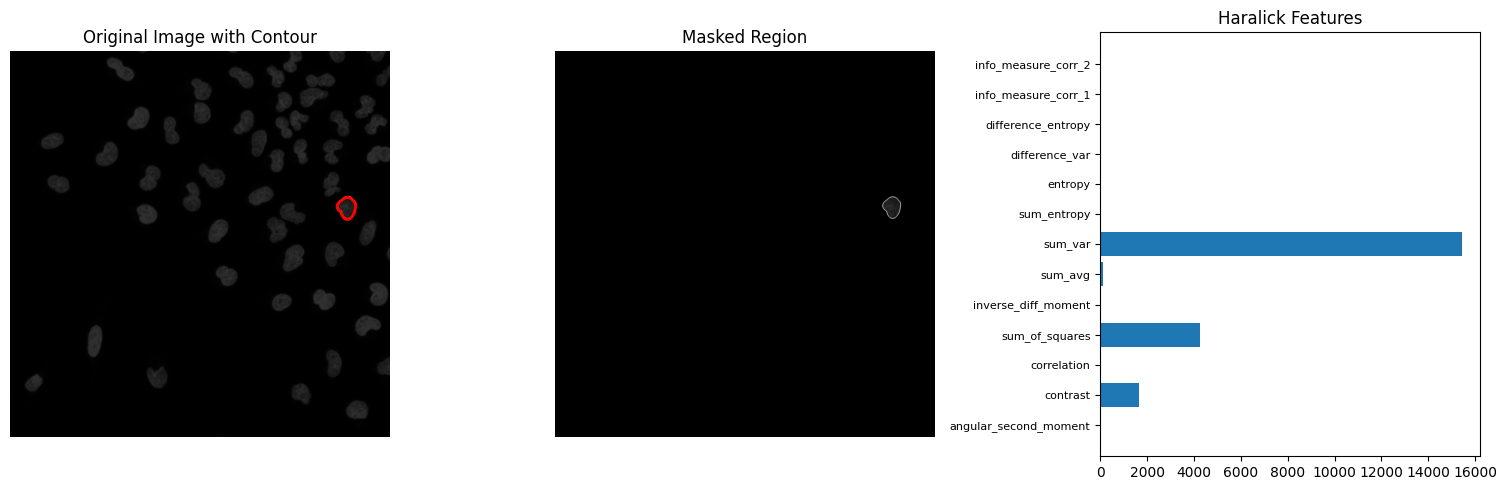

In [53]:
def visualize_analysis(image, contour, features):
    """
    Visualize the original image, masked region, and Haralick features
    
    Parameters:
    -----------
    image : numpy.ndarray
        Original image
    contour : numpy.ndarray
        OpenCV contour array
    features : dict
        Dictionary of Haralick features
    """
    # Create mask
    mask = create_mask_from_contour(contour, image.shape)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image with contour
    axes[0].imshow(image, cmap='gray')
    contour_plot = contour.squeeze().T
    axes[0].plot(contour_plot[0], contour_plot[1], 'r-', linewidth=2)
    axes[0].set_title('Original Image with Contour')
    axes[0].axis('off')
    
    # Masked region
    masked_img = image.copy()
    masked_img[~mask.astype(bool)] = 0
    axes[1].imshow(masked_img, cmap='gray')
    axes[1].set_title('Masked Region')
    axes[1].axis('off')
    
    # Feature values
    y_pos = np.arange(len(features))
    axes[2].barh(y_pos, list(features.values()))
    axes[2].set_yticks(y_pos)
    axes[2].set_yticklabels(list(features.keys()), fontsize=8)
    axes[2].set_title('Haralick Features')
    
    plt.tight_layout()
    return fig

fig = visualize_analysis(img_gray, contour, analyze_cell_texture(img_gray, contour)[0])

## Intensity

In [213]:
def calculate_average_intensity(image, mask):
  masked_pixels = image[mask == 1]
  print(masked_pixels.shape)
  average_intensity = np.mean(masked_pixels)
  return average_intensity

print(calculate_average_intensity(image_bgr, masks[0]))

(7456, 3)
55.33436158798283


In [214]:
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY) 

height, width = image_gray.shape

# Calculate the bounding box dimensions (half the width and height)
bbox_width = int(width / 2)
bbox_height = int(height / 2)

# Calculate the center coordinates of the image
center_x = int(width / 2)
center_y = int(height / 2)

# Define the bounding box as a tuple (x, y, width, height)
bounding_box = (center_x - bbox_width // 2, center_y - bbox_height // 2, bbox_width, bbox_height)

# Slice the image to obtain the bounding box region
roi = image_gray[bounding_box[1]:bounding_box[1] + bounding_box[3], bounding_box[0]:bounding_box[0] + bounding_box[2]]

# Calculate the minimum intensity value within the bounding box
background = np.min(roi)

print(background)

0


In [44]:
def getting_new_mask(image, masks, background):   
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    new_masks = []
    for mask in masks:
        masked_pixels = image_gray[mask == 1]
        max_pixel = max(masked_pixels)
        filtered_pixels = []
        for pixel in masked_pixels:
            #print(pixel)
            if pixel > (max_pixel - background) * 0.2:
                filtered_pixels.append(pixel)
            else:
                filtered_pixels.append(0)
        new_mask = np.zeros_like(mask)
        new_mask[mask == 1] = filtered_pixels
        new_masks.append(new_mask)

    return np.array(new_masks)

new_masks = getting_new_mask(image_bgr, masks, background)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


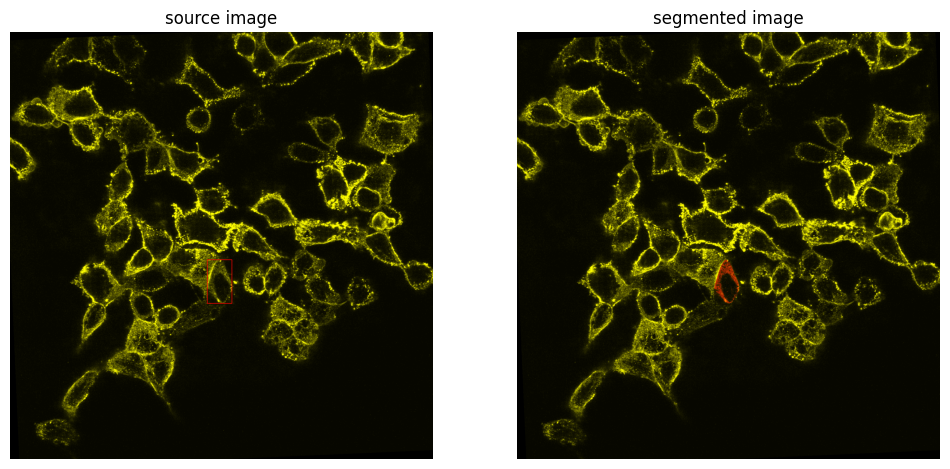

In [45]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=new_masks),
    mask=new_masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [46]:
def calculate_average_intensity(image, mask):
  masked_pixels = image[mask == 1]
  print(masked_pixels.shape)
  average_intensity = np.mean(masked_pixels)
  return average_intensity

print(calculate_average_intensity(image_bgr, new_masks[0])-background)

(6222, 3)
57.240972891888994
